In [1]:
# Set width of Jupyter cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [576]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import glob
import os
import json
import geopy.distance
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from datetime import date
from dateutil.relativedelta import relativedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import foodie_features
import yelp_data_cleaning
import lifelines
import pickle

In [3]:
pd.set_option('display.max_row', 200)
pd.set_option('display.max_columns', 25)

In [4]:
def pull_raw_business_data():
    raw_businesses_df = pd.read_json('yelp_reviews/business.json',lines=True)
    return raw_businesses_df

In [5]:
NOV_14_2018 = date(2018, 11, 14)

def calculate_additional_features(businesses_df, reviews_df):
    
    open_restaurants_yelp_api_data_df = pd.read_pickle('./open_restaurants_yelp_api_data_df.pkl').rename(columns={'price':'cost'})
    open_restaurants_yelp_api_data_df['cost'] = open_restaurants_yelp_api_data_df['cost'].map(lambda x: len(x))
    businesses_df['latitude'].update(open_restaurants_yelp_api_data_df['latitude'])
    businesses_df['longitude'].update(open_restaurants_yelp_api_data_df['longitude'])
    
    # is restaurant claimed
    businesses_df['is_claimed'] = [False for i in range(businesses_df.shape[0])]
    businesses_df['is_claimed'].update(open_restaurants_yelp_api_data_df['is_claimed'])
    businesses_df['is_claimed'] = businesses_df['is_claimed'].apply(lambda x: 1 if x is True else 0)
    
    # compute actual review counts since the dataset is wrong
    businesses_df['actual_review_count'] = reviews_df['business_id'].value_counts()
    
    # compute actual star rating based on actual reviews since the dataset might be wrong and yelp doesn't compute precise ratings
    businesses_df['actual_stars'] = reviews_df.groupby('business_id')['stars'].mean()
    
    # is restaurant a chain (find if business name is not unique)
    chains = businesses_df[businesses_df.name.duplicated(keep=False)].sort_values(by='name').name.unique()
    businesses_df['is_chain'] = businesses_df.name.isin(chains)
    businesses_df['is_chain'] = businesses_df['is_chain'].apply(lambda x: 1 if x is True else 0)
    
    # check if location has multiple closures (TODO fix the fact that the first duplicate location shouldn't matter)
    duplicate_lat_filter = businesses_df.latitude.duplicated(keep=False)
    duplicate_long_filter = businesses_df.longitude.duplicated(keep=False)
    duplicate_locations_df = businesses_df[ (duplicate_lat_filter) & (duplicate_long_filter) ].sort_values(by='latitude')[['latitude','longitude']]
    duplicate_locations = businesses_df.isin(duplicate_locations_df)
    
    businesses_df['duplicate_location'] = duplicate_locations.latitude & duplicate_locations.longitude
    businesses_df['duplicate_location'] = businesses_df['duplicate_location'].apply(lambda x: 1 if x is True else 0)
        
    # add if business has parking
    parking_attrbs = [(key, value[u'BusinessParking']) \
                      if value is not None and 'BusinessParking' in value else (key, 'False') \
                      for key,value in yelp_businesses_df.attributes.iteritems()]
    has_parking_tuples = [(attrbs[0], 'True' in attrbs[1]) for attrbs in parking_attrbs]
    business_ids, has_parking = zip(*has_parking_tuples)
    has_parking_series = pd.Series(has_parking, business_ids)

    businesses_df['has_parking'] = has_parking_series
    businesses_df['has_parking'] = businesses_df['has_parking'].apply(lambda x: 1 if x is True else 0)
    
    # add in cost of restaurant (TODO fix the fact that some restaurants had incomplete data so have 0 under price)
    price_attrbs = [(key, int(value[u'RestaurantsPriceRange2'])) \
                    if value is not None and 'RestaurantsPriceRange2' in value and value[u'RestaurantsPriceRange2'] != u'None' else (key, 1) \
                    for key, value in yelp_businesses_df.attributes.iteritems() ]
    business_ids, cost_rating = zip(*price_attrbs)
    cost = pd.Series(cost_rating, business_ids)
    
    businesses_df['cost'] = cost
    businesses_df['cost'].update(open_restaurants_yelp_api_data_df['cost'])
    
    # proxy for when restaurant open/closed, make sure to include updated dates
    bus_date_df = reviews_df[reviews_df.business_id.duplicated(keep=False)].sort_values(by=['business_id','date'])
    open_dates = bus_date_df.drop_duplicates(subset=['business_id'],keep='first').set_index('business_id')
    closed_dates = bus_date_df.drop_duplicates(subset=['business_id'],keep='last').set_index('business_id')

    open_closed_dates_df = pd.DataFrame(data={'open_dates' : open_dates.date, 'closed_dates' : closed_dates.date, 'is_open' : businesses_df.is_open}, index=open_dates.index)
    open_closed_dates_df['open_dates'] = open_closed_dates_df['open_dates'].apply(lambda x: x.date())
    open_closed_dates_df['closed_dates'] = open_closed_dates_df['closed_dates'].apply(lambda x: x.date())

    businesses_df['open_dates'] = open_closed_dates_df.open_dates
    businesses_df['closed_dates'] = open_closed_dates_df.closed_dates
    
    businesses_df.loc[businesses_df['is_open'] == 1, 'days_since_closed'] = 0
    businesses_df.loc[businesses_df['is_open'] == 1, 'closed_dates'] = NOV_14_2018 # 2018-11-14 is the last day in this dataset
    
    closed_ages = NOV_14_2018 - pd.to_datetime(closed_dates.date, format='%Y%m%d').dt.date
    open_ages = businesses_df['closed_dates'] - pd.to_datetime(open_dates.date, format='%Y%m%d').dt.date
    
    businesses_df['age (in days)'] = open_ages.dt.days
    businesses_df['days_since_closed'] = closed_ages.dt.days
    
    # relative review count, rating, price

    return chains, duplicate_locations_df

In [6]:
reload(foodie_features), reload(yelp_data_cleaning)

(<module 'foodie_features' from 'foodie_features.pyc'>,
 <module 'yelp_data_cleaning' from 'yelp_data_cleaning.pyc'>)

In [373]:
VEGAS_VISITORS_BY_YEAR = {'2018' : 42.12, '2017': 39.01, '2016': 42.94, '2015' : 42.31, '2014' : 41.13, '2013' : 39.67, '2012' : 39.73, '2011' : 38.93, '2010' : 37.34, '2009' : 36.35}
VEGAS_VISITORS_2018_BY_MONTH = {'1' : 3393900, '2' : 3130400, '3' : 3749800, '4'  : 3548000, '5'  : 3630400, '6'  : 3565400,\
                                '7' : 3659600, '8' : 3555200, '9' : 3457500, '10' : 3680600, '11' : 3478500, '12' : 3267600 }
VEGAS_POPULATION_BY_YEAR = {'2018' : 42.12, '2017': 39.01, '2016': 42.94, '2015' : 42.31, '2014' : 41.13, '2013' : 39.67, '2012' : 39.73, '2011' : 38.93, '2010' : 37.34, '2009' : 36.35}
def build_X_and_y(businesses_df, reviews_df, date, load_NLP=True, forecast_months=[1, 3, 6, 9], ignore_distance=False, do_distance=False, features=None):
    """
    businesses_df: dataframe of businesses 
    date: needs to be in a date object from the datetime library
    """
    date_str = date.strftime("%Y-%m-%d")
    
    before_date_filter = reviews_df.date <= pd.Timestamp(date)
    after_date_filter = reviews_df.date > pd.Timestamp(date)
        
    reviews_before_date_df = reviews_df[before_date_filter] # all reviews before date (i.e. they were open before date)
    reviews_after_date_df = reviews_df[after_date_filter] # all reviews after date (i.e. they were open after date)
    
    # restaurants with reviews both before and after date
    restaurant_ids = list( set(reviews_before_date_df.business_id.values) & set(reviews_after_date_df.business_id.values) )
    reviews_for_open_businesses = reviews_df[reviews_df.business_id.isin(restaurant_ids)]
    reviews_for_open_businesses_before_date = reviews_for_open_businesses[before_date_filter]
    
    # find number of other restaurants with same yelp categories -- TODO think about whether it should be at the time of date 
    business_category_counts = foodie_features.calculate_category_counts(businesses_df)
    
    if forecast_months is not None:
        # NLP score -- grab 3 most recent reviews since that's what allowed by yelp
        sentiment, avg_review_length = foodie_features.calculate_review_sentiment_and_length(reviews_for_open_businesses_before_date, date_str=date_str, load_NLP=load_NLP)
    
        # compute review count and rating before date
        review_count_on_date = reviews_for_open_businesses_before_date['business_id'].value_counts()
        rating_on_date = reviews_for_open_businesses_before_date.groupby('business_id')['stars'].mean()
        
        # compute smart rating (using if the reviews were useful)
        smart_rating_on_date = foodie_features.calculate_smart_ratings(reviews_for_open_businesses_before_date)
    else:
        # NLP score -- grab 3 most recent reviews since that's what allowed by yelp
        sentiment, avg_review_length = foodie_features.calculate_review_sentiment_and_length(reviews_df, date_str=date_str, load_NLP=load_NLP)
    
        # compute review count and rating before date
        review_count_on_date = businesses_df['actual_review_count']
        rating_on_date = businesses_df['actual_stars']
        
        # compute smart rating (using if the reviews were useful)
        smart_rating_on_date = foodie_features.calculate_smart_ratings(reviews_df)
    
    # get number of businesses within fixed distance
    if ignore_distance == False:
        count_of_businesses_within_a_tenth_mile = pd.Series()
        count_of_businesses_within_a_quarter_mile = pd.Series()
        count_of_businesses_within_a_half_mile = pd.Series()
        count_of_businesses_within_1_mile = pd.Series()
        count_of_businesses_within_5_miles = pd.Series()
        count_of_businesses_within_10_miles = pd.Series()
    
        for _, city_df in businesses_df.reindex(restaurant_ids).groupby('city'):
            if do_distance == True:        
                coords = city_df[['latitude','longitude']].values
                geopy_distance_func = lambda x,y: geopy.distance.distance(x,y).miles
                distances = pdist(coords, metric=geopy_distance_func)
                np.savetxt('distances_all_%s_%s.csv'%(city_df.city.unique()[0], date_str), distances, delimiter=',')
            else:
                distances = np.genfromtxt('distances_all_%s_%s.csv'%(city_df.city.unique()[0], date_str), delimiter=',')
            dist_matrix = squareform(distances)
            count_of_businesses_within_a_tenth_mile = count_of_businesses_within_a_tenth_mile.append( pd.Series( np.sum((dist_matrix < 0.1),axis=1) - 1, index = city_df.index ) )
            count_of_businesses_within_a_quarter_mile = count_of_businesses_within_a_quarter_mile.append ( pd.Series( np.sum((dist_matrix < 0.25),axis=1) - 1, index = city_df.index ) )
            count_of_businesses_within_a_half_mile = count_of_businesses_within_a_half_mile.append ( pd.Series( np.sum((dist_matrix < 0.5),axis=1) - 1, index = city_df.index ) )
            count_of_businesses_within_1_mile = count_of_businesses_within_1_mile.append ( pd.Series( np.sum((dist_matrix < 1),axis=1) - 1, index = city_df.index ) )
            count_of_businesses_within_5_miles = count_of_businesses_within_5_miles.append ( pd.Series( np.sum((dist_matrix < 5),axis=1) - 1, index = city_df.index ) )
            count_of_businesses_within_10_miles = count_of_businesses_within_10_miles.append ( pd.Series( np.sum((dist_matrix < 10),axis=1) - 1, index = city_df.index ) )
    
    data = businesses_df.copy()
    if forecast_months is not None:
        data = data.reindex(restaurant_ids)
    
    data['review_count_before_date'] = review_count_on_date
    data['rating_before_date'] = rating_on_date
    data['smart_rating_before_date'] = smart_rating_on_date
    data['age_at_date'] = (date - data['open_dates']).dt.days  
    data['sentiment'] = sentiment
    data['avg_review_length'] = avg_review_length
    data['business_category_counts'] = business_category_counts
    if ignore_distance == False:
        data['num_within_a_tenth_mile_at_date'] = count_of_businesses_within_a_tenth_mile
        data['num_within_a_quarter_mile_at_date'] = count_of_businesses_within_a_quarter_mile
        data['num_within_a_half_mile_at_date'] = count_of_businesses_within_a_half_mile
        data['num_within_1_mile_at_date'] = count_of_businesses_within_1_mile
        data['num_within_5_miles_at_date'] = count_of_businesses_within_5_miles
        data['num_within_10_miles_at_date'] = count_of_businesses_within_10_miles
    data = data.join(pd.get_dummies(data['cost'],prefix = 'cost')).drop(['cost'], axis = 1 )
    data = data.join(pd.get_dummies(data['city'],prefix = 'city')).drop(['city'], axis = 1 )
    if forecast_months is None:
            data['is_open'] = businesses_df['is_open']#.replace({0:1, 1:0})
        
    if features is not None:
        data = data[features]
    
    #### TARGET VARIABLE -- Is a restaurant open 6 months after the input date ####
    if forecast_months is not None:
        for forecast_month in forecast_months:
            forecast_filter = reviews_df.date > pd.Timestamp(date + relativedelta(months=forecast_month))
            data['closed_forecast_%s_months'%forecast_month] = foodie_features.calculate_future_restaurant_closure(businesses_df, restaurant_ids, reviews_for_open_businesses, forecast_filter)

    return data

In [66]:
raw_businesses_df = pull_raw_business_data()

In [67]:
cities = ['Las Vegas']
yelp_businesses_df, categories = yelp_data_cleaning.clean_business_data( raw_businesses_df, \
                                                                         type_of_business_list=['Restaurant'], \
                                                                         city_filter_list=cities, \
                                                                         remove_hours=True, \
                                                                         required_num_of_closed_thresh_in_city=1000
                                                                       )
#del raw_businesses_df
yelp_businesses_df

,address,attributes,categories,city,is_open,latitude,longitude,name,review_count,stars
business_id,,,,,,,,,,
PZ-LZzSlhSe9utkQYU8pFg,"1775 E Tropicana Ave, Ste 29","{u'BusinessParking': u'{'garage': False, 'stre...","Restaurants, Italian",Las Vegas,0,36.100016,-115.128529,Carluccio's Tivoli Gardens,40,4.0
tstimHoMcYbkSC4eBA1wEg,6055 E Lake Mead Blvd,"{u'GoodForMeal': u'{'dessert': False, 'latenig...","Mexican, Restaurants, Patisserie/Cake Shop, Fo...",Las Vegas,1,36.195615,-115.040529,Maria's Mexican Restaurant & Bakery,184,4.5
kANF0dbeoW34s2vwh6Umfw,6125 Spring Mountain Rd,"{u'BusinessParking': u'{'garage': False, 'stre...","Fast Food, Food, Restaurants, Ice Cream & Froz...",Las Vegas,0,36.125031,-115.225620,Dairy Queen,33,2.0
6fPQJq4f_yiq1NHn0fd11Q,3655 Las Vegas Blvd S,"{u'BusinessParking': u'{'garage': True, 'stree...","French, Restaurants, Creperies",Las Vegas,1,36.112527,-115.171351,La Creperie,535,3.5
k-dDZvTeLysoJvjHI-qr9g,2411 W Sahara Ave,"{u'Alcohol': u'u'beer_and_wine'', u'HasTV': u'...","Buffets, Restaurants",Las Vegas,1,36.142116,-115.174252,Feast Buffet,287,3.0
PWjgwphd2prhtqTPWwLbXw,"3500 Las Vegas Blvd S, Ste E11","{u'BusinessParking': u'{'garage': True, 'stree...","Sandwiches, Restaurants, Delis, Desserts, Food",Las Vegas,0,36.117327,-115.176501,Stage Deli Of Las Vegas,28,3.5
eY98EH_PHGnJVaJ7t2UpoQ,1263 Silverado Ranch Blvd,"{u'GoodForMeal': u'{'dessert': False, 'latenig...","Middle Eastern, Restaurants, Vegetarian, Juice...",Las Vegas,0,36.012764,-115.136056,Pita Pit,77,4.0
iwGhazq9eP51PSerTrMrwg,"3342 E Sandhill Rd, Ste 11","{u'Alcohol': u'u'full_bar'', u'HasTV': u'True'...","Dive Bars, Food, Bars, Pubs, Restaurants, Nigh...",Las Vegas,1,36.129040,-115.091294,Mr G's Pub & Grub,27,4.0
0G83H_zoum-Q4bWU2olTqQ,"4012 S Rainbow Blvd, Ste J","{u'GoodForMeal': u'{'dessert': True, 'latenigh...","Restaurants, Food, Delis, Desserts, Bakeries, ...",Las Vegas,1,36.116169,-115.241852,Bonjour Bakery & Deli,39,4.5


In [10]:
business_ids = yelp_businesses_df.index.values
reviews_df = yelp_data_cleaning.clean_reviews_data(business_ids)
reviews_df

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,HojKatUfX4UHWaPqtl63NQ,5,2017-07-17 10:32:50,3,ywpTVqkG1a-SpsIN-PImqA,4,Opened in October 2015 as a rebrand of culinar...,6,U4INQZOPSUaj8hMjLlZ3KA
1,pHJu8tj3sI8eC5aIHLFEfQ,0,2016-01-29 04:44:56,0,hBXTJJWYLRye5KnGjN8Dcw,5,I had a very yummy pizza at Nora's tonight. T...,0,YgGp54AKCFqCIKcQhGHwRw
2,WX8cx6tfFcEn0cK4cIbWag,0,2018-10-28 04:05:42,0,_hX5S_Jo0SO6jklB3Lu7wA,1,"First, we made a reservation & they weren't pr...",0,OS5p_5bdHXKCcN7ZEK2TXQ
3,3h5jLa-kbHg0cL7v9En0Lg,0,2012-12-30 20:09:04,0,ek-kaQnj6PLEwZGz_LSrdw,4,Low Prices - Great Food - Very nice Setting\nW...,4,d2WVEYfpHMtTjDwiLh_r6A
4,rdZ6xVABSoOVeAIiCaEj4w,0,2010-09-27 07:08:59,0,aPWQLR2RL8N3u03QWsXHYw,4,This is my first time here and my first time h...,0,7weuSPSSqYLUFga6IYP4pg
5,G4hjhtA_wQ-tSOGpgGlDjw,0,2017-09-03 02:47:37,0,C0lqD5lXMB2J8FudJV4uDw,5,Really really good! Get the pulpo taco! Very c...,0,uGcpEaM2ecZ2RRHsN-e1LA
6,PXShA3JZMXr2mEH3on5clw,2,2015-03-15 19:50:44,1,kvECsBzKB8nsB1xCOPcapw,5,Got the Stuffed French Toast and it was a glor...,1,vUGsv8bgAAWOsuoJMziS0g
7,OPxWcHK96_cbmiF7legDnA,0,2011-08-22 15:27:54,0,NoBYu_VJ_3aSOh0-wCR8KQ,2,Really not the best experience.\n\nThe waiter ...,0,f_s-9gqc9T8pXXu8pWMFPQ
8,h7s4MRVvB726jWHCHiQ9kw,2,2016-09-17 04:38:42,1,7zkdXbSYRzhnSWIjT9W4Ag,4,Lauren was our server and we had a party of si...,2,4AjocDGdZNPyhBLQpxpa_Q
9,5fpXjlC71y_mKORnPdX5zA,0,2016-08-05 05:59:12,0,zwHT6zP1debYSa0g20eK0Q,1,Currently sitting in the drive thru. 15 minute...,0,J4W2abNDYv4xyU2ff4V2qQ


In [68]:
chains, duplicate_locations_df = calculate_additional_features(yelp_businesses_df, reviews_df)

In [69]:
yelp_businesses_df

,address,attributes,categories,city,is_open,latitude,longitude,name,review_count,stars,is_claimed,actual_review_count,actual_stars,is_chain,duplicate_location,has_parking,cost,open_dates,closed_dates,days_since_closed,age (in days)
business_id,,,,,,,,,,,,,,,,,,,,,
PZ-LZzSlhSe9utkQYU8pFg,"1775 E Tropicana Ave, Ste 29","{u'BusinessParking': u'{'garage': False, 'stre...","Restaurants, Italian",Las Vegas,0,36.100016,-115.128529,Carluccio's Tivoli Gardens,40,4.0,0,41,4.097561,0,0,1,2,2007-08-23,2016-08-09,827,3274
tstimHoMcYbkSC4eBA1wEg,6055 E Lake Mead Blvd,"{u'GoodForMeal': u'{'dessert': False, 'latenig...","Mexican, Restaurants, Patisserie/Cake Shop, Fo...",Las Vegas,1,36.195598,-115.040622,Maria's Mexican Restaurant & Bakery,184,4.5,1,189,4.301587,0,0,1,2,2010-03-23,2018-11-14,0,3158
kANF0dbeoW34s2vwh6Umfw,6125 Spring Mountain Rd,"{u'BusinessParking': u'{'garage': False, 'stre...","Fast Food, Food, Restaurants, Ice Cream & Froz...",Las Vegas,0,36.125031,-115.225620,Dairy Queen,33,2.0,0,33,2.242424,1,0,1,1,2008-11-02,2017-01-05,678,2986
6fPQJq4f_yiq1NHn0fd11Q,3655 Las Vegas Blvd S,"{u'BusinessParking': u'{'garage': True, 'stree...","French, Restaurants, Creperies",Las Vegas,1,36.112725,-115.170350,La Creperie,535,3.5,1,543,3.648250,0,0,1,2,2005-12-25,2018-11-14,8,4707
k-dDZvTeLysoJvjHI-qr9g,2411 W Sahara Ave,"{u'Alcohol': u'u'beer_and_wine'', u'HasTV': u'...","Buffets, Restaurants",Las Vegas,1,36.142950,-115.174937,Feast Buffet,287,3.0,1,295,2.966102,1,0,1,2,2007-10-27,2018-11-14,1,4036
PWjgwphd2prhtqTPWwLbXw,"3500 Las Vegas Blvd S, Ste E11","{u'BusinessParking': u'{'garage': True, 'stree...","Sandwiches, Restaurants, Delis, Desserts, Food",Las Vegas,0,36.117327,-115.176501,Stage Deli Of Las Vegas,28,3.5,0,28,3.678571,0,0,1,2,2006-06-12,2016-03-18,971,3567
eY98EH_PHGnJVaJ7t2UpoQ,1263 Silverado Ranch Blvd,"{u'GoodForMeal': u'{'dessert': False, 'latenig...","Middle Eastern, Restaurants, Vegetarian, Juice...",Las Vegas,0,36.012764,-115.136056,Pita Pit,77,4.0,0,78,4.012821,1,1,1,1,2014-01-07,2016-12-18,696,1076
iwGhazq9eP51PSerTrMrwg,"3342 E Sandhill Rd, Ste 11","{u'Alcohol': u'u'full_bar'', u'HasTV': u'True'...","Dive Bars, Food, Bars, Pubs, Restaurants, Nigh...",Las Vegas,1,36.129050,-115.091350,Mr G's Pub & Grub,27,4.0,1,28,3.892857,0,0,1,1,2013-05-04,2018-11-14,58,2020
0G83H_zoum-Q4bWU2olTqQ,"4012 S Rainbow Blvd, Ste J","{u'GoodForMeal': u'{'dessert': True, 'latenigh...","Restaurants, Food, Delis, Desserts, Bakeries, ...",Las Vegas,1,36.116100,-115.241800,Bonjour Bakery & Deli,39,4.5,1,39,4.384615,0,0,1,1,2017-08-17,2018-11-14,207,454


In [710]:
features = ['is_chain', 'duplicate_location', 'cost_1', 'cost_2', 'cost_3', 'cost_4', 'is_claimed', 'sentiment', 'avg_review_length', \
            'review_count_before_date', 'rating_before_date' ]# + ['city_Las Vegas']#['city_%s'%city for city in cities]
data = build_X_and_y(yelp_businesses_df, reviews_df, date(2018, 1, 1), forecast_months=[1, 3, 6, 9], ignore_distance=False, load_NLP=True, do_distance=False, features=features)
X = data[features]

/home/jeremy/.local/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
foodie_features.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  category_counts.append( df[df.categories.str.contains(category)].shape[0] )
foodie_features.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  category_counts.append( df[df.categories.str.contains(category)].shape[0] )


Checkpoint : 0
Checkpoint : 10000


foodie_features.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews_after_date_df = reviews_for_open_businesses[after_date_filter]
foodie_features.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews_after_date_df = reviews_for_open_businesses[after_date_filter]
foodie_features.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews_after_date_df = reviews_for_open_businesses[after_date_filter]
foodie_features.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews_after_date_df = reviews_for_open_businesses[after_date_filter]


In [711]:
data[ [column for column in data if column.startswith('closed_forecast')] ].sum()

closed_forecast_1_months     30
closed_forecast_3_months     77
closed_forecast_6_months    146
closed_forecast_9_months    218
dtype: int64

In [843]:
forecast_length = '1_months'
y = data['closed_forecast_%s'%forecast_length]

In [713]:
#X = data.append(pd.read_csv('data_2018_1_1.csv').set_index('business_id'))[features]
#y = data.append(pd.read_csv('data_2018_1_1.csv').set_index('business_id'))['closed_forecast_6_months']

In [714]:
#data.to_csv('data_2018_1_1.csv')

In [715]:
# EDA of features
num_of_close = y[y == 1].shape[0]
num_of_open = y[y == 0].shape[0]
print "Number open(closed) in dataset: %s(%s)"%(num_of_open, num_of_close)

num_cost_1_closed = float(X[ (X.index.isin(y[y == 1].index)) & (X.cost_1 == 1) ].shape[0])
num_cost_1_open =  float( X[ (X.index.isin(y[y == 0].index)) & (X.cost_1 == 1)].shape[0])
num_cost_2_closed = float( X[ (X.index.isin(y[y == 1].index)) & (X.cost_2 == 1) ].shape[0])
num_cost_2_open = float( X[ (X.index.isin(y[y == 0].index)) & (X.cost_2 == 1)].shape[0])
num_cost_3_closed =  float( X[ (X.index.isin(y[y == 1].index)) & (X.cost_3 == 1) ].shape[0])
num_cost_3_open = float( X[ (X.index.isin(y[y == 0].index)) & (X.cost_3 == 1)].shape[0])
num_cost_4_closed = float( X[ (X.index.isin(y[y == 1].index)) & (X.cost_4 == 1) ].shape[0])
num_cost_4_open = float( X[ (X.index.isin(y[y == 0].index)) & (X.cost_4 == 1)].shape[0])

avg_cost_closed = (1 * num_cost_1_closed + 2 * num_cost_2_closed + 3 * num_cost_3_closed + 4 * num_cost_4_closed) / num_of_close
avg_cost_open = (1 * num_cost_1_open + 2 * num_cost_2_open + 3 * num_cost_3_open + 4 * num_cost_4_open) / num_of_open

print "Avg cost for closed restaurants: ", avg_cost_closed
print "Avg cost for open resturants: ", avg_cost_open

print "Sentiment for closed:", X[X.index.isin(y[y == 1].index)].sentiment.mean(), "Sentiment for open:", X[X.index.isin(y[y == 0].index)].sentiment.mean()

print "Avg review length for closed:", X[X.index.isin(y[y == 1].index)].avg_review_length.mean(), "Avg review length for open:", X[X.index.isin(y[y == 0].index)].avg_review_length.mean()

print "Avg rating for closed:", X[X.index.isin(y[y == 1].index)].rating_before_date.mean(), "Avg rating for open:", X[X.index.isin(y[y == 0].index)].rating_before_date.mean()

print "Avg review count for closed:", X[X.index.isin(y[y == 1].index)].review_count_before_date.mean(), "Avg review count for open:", X[X.index.isin(y[y == 0].index)].review_count_before_date.mean()

print "Is chain for closed:", X[ (X.index.isin(y[y == 1].index)) & (X.is_chain == 1) ].shape[0], "Is not chain for closed:", X[ (X.index.isin(y[y == 1].index)) & (X.is_chain == 0)].shape[0] 
print "Is chain for open:", X[ (X.index.isin(y[y == 0].index)) & (X.is_chain == 1) ].shape[0], "Is not chain for open:", X[ (X.index.isin(y[y == 0].index)) & (X.is_chain == 0) ].shape[0]

print "Dup loc for closed:", X[ (X.index.isin(y[y == 1].index)) & (X.duplicate_location == 1) ].shape[0], "Not dup loc for closed:", X[ (X.index.isin(y[y == 1].index)) & (X.duplicate_location == 0)].shape[0] 
print "Dup loc for open:", X[ (X.index.isin(y[y == 0].index)) & (X.duplicate_location == 1) ].shape[0], "Not dup loc for open:", X[ (X.index.isin(y[y == 0].index)) & (X.duplicate_location == 0) ].shape[0]

print "Is claimed for closed:", X[ (X.index.isin(y[y == 1].index)) & (X.is_claimed == 1) ].shape[0], "Is not claimed for closed:", X[ (X.index.isin(y[y == 1].index)) & (X.is_claimed == 0)].shape[0] 
print "Is claimed for open:", X[ (X.index.isin(y[y == 0].index)) & (X.is_claimed == 1) ].shape[0], "Is not claimed for open:", X[ (X.index.isin(y[y == 0].index)) & (X.is_claimed == 0) ].shape[0]

Number open(closed) in dataset: 3553(218)
Avg cost for closed restaurants:  1.73394495413
Avg cost for open resturants:  1.60146355193
Sentiment for closed: 0.558308715596 Sentiment for open: 0.488535861713
Avg review length for closed: 473.305810398 Avg review length for open: 475.73848391
Avg rating for closed: 3.73675162011 Avg rating for open: 3.48436626225
Avg review count for closed: 263.532110092 Avg review count for open: 241.701379116
Is chain for closed: 50 Is not chain for closed: 168
Is chain for open: 1534 Is not chain for open: 2019
Dup loc for closed: 25 Not dup loc for closed: 193
Dup loc for open: 312 Not dup loc for open: 3241
Is claimed for closed: 0 Is not claimed for closed: 218
Is claimed for open: 2840 Is not claimed for open: 713


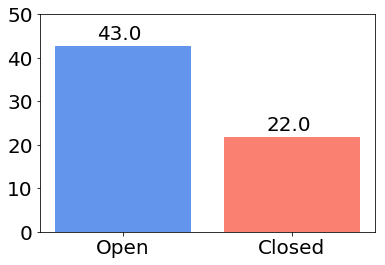

In [716]:
chain_df = pd.DataFrame(data= {'Open': [3100, 4155], 'Closed': [132, 473]}, index= ['Yes','No'] )

objects = ('Open', 'Closed')
y_pos = np.arange(len(objects))
performance = [ 100*float(chain_df.Open.Yes)/(chain_df.Open.Yes + chain_df.Open.No), 100*float(chain_df.Closed.Yes)/(chain_df.Closed.Yes + chain_df.Closed.No) ]

barplot = plt.bar(y_pos, performance, align='center')#, alpha=0.5)
barplot[0].set_color('cornflowerblue')
barplot[1].set_color('salmon')
plt.xticks(y_pos, objects)
xlocs=[i+1 for i in range(0,2)]
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=15)

for i, v in enumerate(performance):
    plt.text(xlocs[i] - 1.15, v + 1.5, str(round(v,0)),fontsize=20)

plt.ylim([0,50])
#plt.tick_params(axis='both', which='major', labelsize=20)
#plt.tick_params(axis='both', which='minor', labelsize=15)

#plt.yticks
#plt.ylabel('Percentage')
#plt.legend()
#plt.title('Programming language usage')

plt.show()

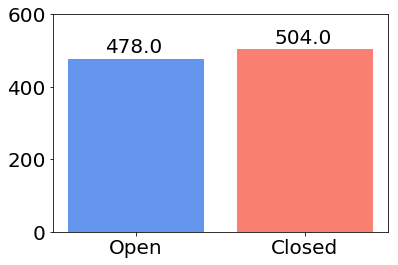

In [717]:
objects = ('Open', 'Closed')
y_pos = np.arange(len(objects))
performance = [ 478, 504 ]

barplot = plt.bar(y_pos, performance, align='center')
barplot[0].set_color('cornflowerblue')
barplot[1].set_color('salmon')
plt.xticks(y_pos, objects)
xlocs=[i+1 for i in range(0,2)]
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=15)

for i, v in enumerate(performance):
    plt.text(xlocs[i] - 1.18, v + 15.1, str(round(v,2)),fontsize=20)

plt.ylim([0,600])

plt.show()

In [844]:
### Train/test split
dropped_columns = []#['business_category_counts','num_rest_within_a_tenth_mile_at_date', 'num_rest_within_a_quarter_mile_at_date', 'num_rest_within_a_half_mile_at_date', \
                   #'num_rest_within_1_mile_at_date','num_rest_within_5_miles_at_date', 'num_rest_within_10_miles_at_date']
X_train, X_test, y_train, y_test = train_test_split(X.drop(dropped_columns,axis=1).values, y.values, test_size=0.2)
X_train_no_val, X_train_val, y_train_no_val, y_train_val = train_test_split(X_train, y_train, test_size=0.2)

In [845]:
#(y == 1).sum(), y.shape

In [846]:
#(y_train == 1).sum(), y_train.shape

In [847]:
#(y_train_no_val == 1).sum(), y_train_no_val.shape

In [848]:
#sns.heatmap(X.corr())

In [849]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.rcParams.update({'font.size': 17})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['Open','Closed'], rotation=45)
    plt.yticks(tick_marks, ['Open','Closed'])
    plt.tick_params(axis='both', which='major')
    plt.tick_params(axis='both', which='minor')
    for (j,i),label in np.ndenumerate(cm):
        plt.text(i,j,label,ha='center',va='center')
        plt.text(i,j,label,ha='center',va='center')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)

In [850]:
param_grid_logistic = {
    'logistic__C': np.logspace(-4, 4, 4),
    'logistic__solver' : [ 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logistic__max_iter' : [500, 1000, 2000]
}
param_grid_rf = {
    'rf__max_depth' : [4, 6, 8],
    'rf__n_estimators' : [500, 1000, 2000]
}
param_grid_xgb = {
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    #'xgb_subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__learning_rate': [0.01, 0.02, 0.05, 0.1],
    'xgb__max_depth': [3, 4, 5]
    }

#pipe = Pipeline([ ( 'scaler', StandardScaler() ), ( 'logistic', LogisticRegression(penalty='l2', class_weight='balanced') ) ])
#grid_search = GridSearchCV(pipe, param_grid_logistic, cv=5, scoring='roc_auc', n_jobs=-1) #roc_auc

#pipe = Pipeline([ ( 'rf', RandomForestClassifier(class_weight='balanced') ) ])
#grid_search = GridSearchCV(pipe, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1) #roc_auc

balanced_class_ratio = float((y_train==0).sum())/(y_train==1).sum()
pipe = Pipeline([ ( 'xgb', xgb.XGBClassifier(scale_pos_weight=balanced_class_ratio) ) ])
grid_search = GridSearchCV(pipe, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
y_pred_train = grid_search.best_estimator_.predict(X_train)
print "F1 Score:", f1_score(y_train, y_pred_train)
print "Precision Score:", precision_score(y_train, y_pred_train)
print "Recall Score:", recall_score(y_train, y_pred_train)
print "Accuracy Score:", accuracy_score(y_train, y_pred_train)
confusion_matrix(y_true=y_train, y_pred=y_pred_train)

Best parameter (CV score=0.910):
{'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0.5, 'xgb__learning_rate': 0.01, 'xgb__min_child_weight': 1, 'xgb__max_depth': 3}
Pipeline(memory=None,
     steps=[('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0.5, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=136.090909091, seed=None,
       silent=True, subsample=1))])
F1 Score: 0.09185803757828812
Precision Score: 0.04814004376367615
Recall Score: 1.0
Accuracy Score: 0.8557692307692307


array([[2559,  435],
       [   0,   22]])

In [859]:
#with open('trained_classifier_%s.pkl'%forecast_length, 'wb') as fid:
#    pickle.dump(grid_search.best_estimator_, fid)

In [867]:
with open('trained_classifier_6_months.pkl', 'rb') as fid:
    gs_model = pickle.load(fid)

In [876]:
gs_model.predict_proba([np.array([ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00, -4.63333333e-03,
        1.55666667e+02,  8.59000000e+02,  4.50000000e+00])])

array([[0.8161156, 0.1838844]], dtype=float32)

In [854]:
fpr, tpr, thresholds = roc_curve(y_test, grid_search.best_estimator_.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
opt_fpr, opt_tpr, opt_threshold = fpr[(tpr + 1 - fpr).argmax()], tpr[(tpr + 1 - fpr).argmax()], thresholds[(tpr + 1 - fpr).argmax()]

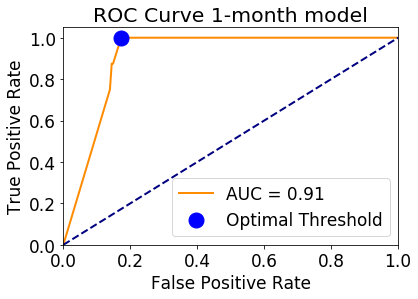

In [855]:
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot([opt_fpr],[opt_tpr],'bo', label='Optimal Threshold' %opt_threshold, markersize=15)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve 1-month model')
plt.legend(loc="lower right")
plt.show()

F1 Score: 0.11111111111111112
Precision Score: 0.059322033898305086
Recall Score: 0.875
Accuracy Score: 0.8516556291390729


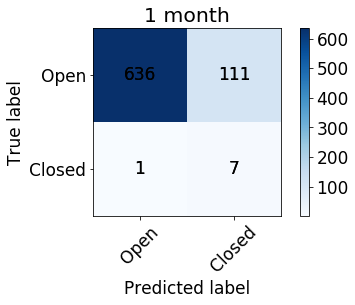

In [856]:
y_pred_roc = np.array([1 if grid_search.best_estimator_.predict_proba(X_test)[i,1] > opt_threshold else 0 for i in range(X_test.shape[0]) ])
print "F1 Score:", f1_score(y_test, y_pred_roc)
print "Precision Score:", precision_score(y_test, y_pred_roc)
print "Recall Score:", recall_score(y_test, y_pred_roc)
print "Accuracy Score:", accuracy_score(y_test, y_pred_roc)
plot_confusion_matrix(confusion_matrix(y_true=y_test, y_pred=y_pred_roc), title='%s'%forecast_length.replace('_',' ')[:-1])

F1 Score: 0.11111111111111112
Precision Score: 0.059322033898305086
Recall Score: 0.875
Accuracy Score: 0.8516556291390729


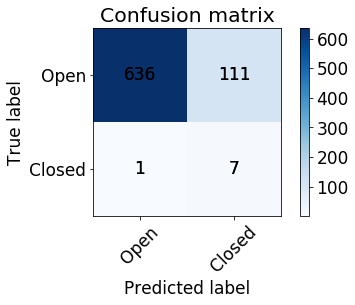

In [857]:
y_pred_test = grid_search.best_estimator_.predict(X_test)
print "F1 Score:", f1_score(y_test, y_pred_test)
print "Precision Score:", precision_score(y_test, y_pred_test)
print "Recall Score:", recall_score(y_test, y_pred_test)
print "Accuracy Score:", accuracy_score(y_test, y_pred_test)
plot_confusion_matrix(confusion_matrix(y_true=y_test, y_pred=y_pred_test))

In [858]:
print X.columns
try:
    print grid_search.best_estimator_.named_steps['scaler'].mean_
    print grid_search.best_estimator_.named_steps['logistic'].coef_
except:
    try:
        print grid_search.best_estimator_.named_steps['xgb'].feature_importances_
    except:
        print grid_search.best_estimator_.named_steps['rf'].feature_importances_

Index([u'is_chain', u'duplicate_location', u'cost_1', u'cost_2', u'cost_3',
       u'cost_4', u'is_claimed', u'sentiment', u'avg_review_length',
       u'review_count_before_date', u'rating_before_date'],
      dtype='object')
[0.         0.         0.         0.         0.         0.
 0.78382367 0.049131   0.         0.03778999 0.1292553 ]


In [866]:
a = grid_search.best_estimator_.predict_proba([np.array([ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00, -4.63333333e-03,
        1.55666667e+02,  8.59000000e+02,  4.50000000e+00])])
a[0][0], a[0][1]

(0.81611514, 0.18388489)

In [658]:
# look at 3 and 4 star restaurants, but make sure to separate these because you've trained on some of them
#data[ (data.cost_3 == 1) | (data.cost_4 == 1) ][features]

#grid_search.best_estimator_.predict(X[ (X.cost_3 == 1) | (X.cost_4 == 1) ].values)
#y[ X[ (X.cost_3 == 1) | (X.cost_4 == 1) ].index ].values

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0])

In [281]:
metrics_df = pd.DataFrame(data = { 'F1':        [0.08,0.22,0.37,0.44], 'Recall'  : [0.80,0.95,0.88,0.96], \
                                   'Precision': [0.04,0.12,0.24,0.28], 'Accuracy': [0.88,0.82,0.87,0.85] }, \
                          index= [1,3,6,9] )
metrics_df

,Accuracy,F1,Precision,Recall
1,0.88,0.08,0.04,0.80
3,0.82,0.22,0.12,0.95
6,0.87,0.37,0.24,0.88
9,0.85,0.44,0.28,0.96


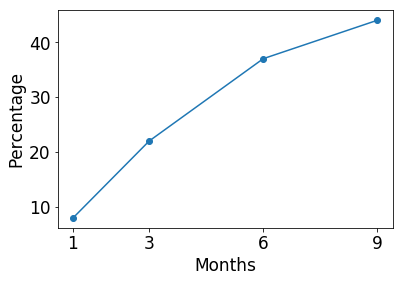

In [300]:
#plt.plot(metrics_df.index,100*metrics_df.Recall, '-o')
#plt.plot(metrics_df.index,100*metrics_df.Accuracy, '-o')
#plt.plot(metrics_df.index,[100*metrics_df.Accuracy.mean() for i in range(metrics_df.Accuracy.shape[0])], '--')
#plt.plot(metrics_df.index,100*metrics_df.Precision, '-o')
plt.plot(metrics_df.index,100*metrics_df.F1, '-o')
plt.xticks(metrics_df.index)
plt.xlabel('Months')
plt.ylabel('Percentage')
#plt.yticks([80, 82, 84, 86, 88, 90])
#plt.title('Accuracy across models')
#plt.legend()

In [ ]:
model = Pipeline([ ( 'scaler', StandardScaler() ), ( 'lr', LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced') ) ])
#model = Pipeline([ ( 'scaler', StandardScaler() ), ( 'lr', RandomForestClassifier(max_depth=5, n_estimators=1000, class_weight='balanced') ) ])
model.fit(X_train_no_val, y_train_no_val)
y_pred_val = model.predict(X_train_val)
print "F1 score:", f1_score(y_train_val, y_pred_val)
print "Accuracy score:", accuracy_score(y_train_val, y_pred_val)
plot_confusion_matrix(confusion_matrix(y_true=y_train_val, y_pred=y_pred_val))

In [ ]:
#model.steps[1][1].coef_

In [ ]:
clf = RandomForestClassifier(max_depth=3, class_weight='balanced')
clf.fit(X_train_no_val, y_train_no_val)
y_pred_val = clf.predict(X_train_val)
print "F1 score:", f1_score(y_train_val, y_pred_val)
#print "Precision Score:", precision_score(y_train_val, y_pred_val)
#print "Recall Score:", recall_score(y_train_val, y_pred_val)
print "Accuracy score:", accuracy_score(y_train_val, y_pred_val)
plot_confusion_matrix(confusion_matrix(y_true=y_train_val, y_pred=y_pred_val))

In [ ]:
clf.feature_importances_

In [ ]:
### Define simplest model
clf = LogisticRegression(solver='lbfgs',max_iter=1000,random_state=42,class_weight='balanced')
clf.fit(X_train_no_val, y_train_no_val)
y_pred_val = clf.predict(X_train_val)
print "F1 score:", f1_score(y_train_val, y_pred_val)
#print "Precision Score:", precision_score(y_train_val, y_pred_val)
#print "Recall Score:", recall_score(y_train_val, y_pred_val)
print "Accuracy score:", accuracy_score(y_train_val, y_pred_val)
plot_confusion_matrix(confusion_matrix(y_true=y_train_val, y_pred=y_pred_val)) #(clf.predict_proba(X_train_val) >= 0.5).astype(int).sum(axis=1)) #y_pred_val

In [ ]:
# DO AUC/ROC, CHECK YEARS, GET MORE TIME BY MOVING BACK IN TIME, ALSO CHECK DIFFERENT FORECAST LENGTHS (1 MONTH, 3 MONTHS, 6 MONTHS), COMPARE ACROSS CITIES

In [ ]:
balanced_class_ratio = float((y_train_no_val==0).sum())/(y_train_no_val==1).sum()
clf = xgb.XGBClassifier(scale_pos_weight=balanced_class_ratio, learning_rate=0.05)
clf.fit(X_train_no_val, y_train_no_val)
y_pred_val = clf.predict(X_train_val)
print "F1 Score:", f1_score(y_train_val, y_pred_val)
#print "Precision Score:", precision_score(y_train_val, y_pred_val)
#print "Recall Score:", recall_score(y_train_val, y_pred_val)
print "Accuracy Score:", accuracy_score(y_train_val, y_pred_val)
#print "Confusion matrix:", confusion_matrix(y_true=y_train_val, y_pred=y_pred_val)
plot_confusion_matrix(confusion_matrix(y_true=y_train_val,y_pred=y_pred_val))

In [ ]:
clf.feature_importances_

In [ ]:
#balanced_class_ratio = float( (y_train==0).sum() ) / (y_train==1).sum()
#clf = xgb.XGBClassifier(scale_pos_weight=balanced_class_ratio)
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)
#print "F1 Score:", f1_score(y_test, y_pred)
#print "Precision Score:", precision_score(y_test, y_pred)
#print "Recall Score:", recall_score(y_test, y_pred)
#print "Accuracy Score:", accuracy_score(y_test, y_pred)
#print "Confusion matrix:", confusion_matrix(y_true=y_test, y_pred=y_pred)

In [ ]:
#### Save important files to be used for model in web app
business_names_str = np.array([ str(name.encode('utf-8')) for name in yelp_businesses_df.name.values ]).astype(str)
np.savetxt('VivaLasFoodieRestaurantNames.csv', np.vectorize(lambda x: x.decode('UTF-8'))(business_names_str), delimiter=',', fmt='%s')

np.savetxt('chains.csv', np.vectorize(lambda x: x.decode('UTF-8'))(np.array([str(name.encode('utf-8')) for name in chains]).astype(str)),delimiter=',', fmt='%s')

np.savetxt('duplicate_locations.csv', duplicate_locations_df.values, delimiter=',')

## name_to_id_dict.json
with open('name_to_id_dict.json', 'w') as fp:
    json.dump(name_to_id_dict, fp)

## id_to_features_dict.json
with open('id_to_features_dict.json', 'w') as fp:
    json.dump(id_to_features_dict, fp)

In [ ]:
def dist_of_open_businesses_in_city(businesses_df, categories):
    open_businesses = []
    closed_businesses = []
    valid_categories = []
    
    for category in categories:
        category_df = businesses_df[businesses_df['categories'].str.contains(category, na=False)]
        num_open = category_df[category_df.is_open == 1].shape[0]
        num_closed = category_df[category_df.is_open == 0].shape[0]
        if num_open + num_closed > 100 and num_closed > 50:
            open_businesses.append(category_df[category_df.is_open == 1].shape[0])
            closed_businesses.append(category_df[category_df.is_open == 0].shape[0]) 
            valid_categories.append(category)
        
    city_business_distribution = pd.DataFrame(data={'Open' : open_businesses, 'Closed' : closed_businesses}, index=valid_categories)
    
    return city_business_distribution

city_business_distribution = dist_of_open_businesses_in_city(yelp_businesses_df, categories)
city_business_distribution

In [ ]:
#############
# FOCUS ON SCOPE AND TARGET AUDIENCE -- WHO WOULD USE THE PRODUCT AND WHY -- Just pick Las Vegas
# WHAT ARE YOU ACTUALLY PREDICTING...

# Signals: 
#      Age of business? Proxy can be time of first review -- Done
#      Density of other businesses in area? -- Done
#      Rating count? -- Done
#      Star rating? -- Done
#      Location? -- Done
#      Semantic analysis of text? -- Done
#      Hours of business? -- Ignore
#      Accept credit card? -- Ignore
#      Offers parking? -- Done
#      Is the business a chain? Are there others in the area? -- Done
#      Price relative to competitors? Review count relative to competitors? Star rating relative to competitors?
#      Look at geography in a given city. Are there locations in the city where businesses don't succeed -- Ignore for now
#      Useful, cool, funny reviews? -- Ignore/Done
#      Are some users more impactful?
#      Get city population/neighborhood data -- Ignore
#      Average length of review text -- Done
#      Investigate other cities
#      Change the date and forecast period
#      Number of restaurants with same category in city

#      Do AWS deployment
#      Flask/web app, think about how the input ---> model ---> output will work
#      Website output needs to show information about the restaurant
#      Change focus to food tourism where people are specifically picking restaurants, the project is not just about Las Vegas (Las Vegas is just a city in the food tourism space)
#      Numbers/stats can all be about food tourism now
#      Look at cost rating and see about fine dining (or not one $ restaurants) since those are ones that people actually care about

In [ ]:
# find out distribution of types of businesses in dataset
# find out closed business distribution by city, state
# perhaps look into time
# semantic analysis of text
# do the business hours matter in when stores open or close? are they related to type of business?
# does length of business name matter?
# does star number count?
# does business accept credit card matter?
# does parking matter?
# HuggingFace library BERT based on pytorch
# do certain user reviews matter?
# who is the user?
# how is it going to be used?

In [381]:
features = ['is_chain','duplicate_location','cost_2','cost_3','cost_4', 'is_claimed', 'sentiment', 'avg_review_length', \
            'review_count_before_date', 'rating_before_date','age (in days)', 'is_open' ]# + ['city_Las Vegas']#['city_%s'%city for city in cities]
data_survival = build_X_and_y(yelp_businesses_df, reviews_df, NOV_14_2018, forecast_months=None, load_NLP=True, ignore_distance=True, do_distance=True, features=features)
data_survival_train, data_survival_test = train_test_split(data_survival, test_size=0.2)
data_survival_train

/home/jeremy/.local/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
foodie_features.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  category_counts.append( df[df.categories.str.contains(category)].shape[0] )
foodie_features.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  category_counts.append( df[df.categories.str.contains(category)].shape[0] )


,is_chain,duplicate_location,cost_2,cost_3,cost_4,is_claimed,sentiment,avg_review_length,review_count_before_date,rating_before_date,age (in days),is_open
business_id,,,,,,,,,,,,
lgThAiX5kMvSxizl2tQ1hA,0,0,0,0,0,0,0.490367,205.666667,17,4.235294,1800,0
JTFFtWy_chbsHTs95yD_2Q,0,0,1,0,0,0,-0.098567,352.333333,910,3.279121,4372,0
DJXZrIi4k1Iyd1mQRwxIMg,0,0,0,0,0,0,0.891900,489.000000,71,3.422535,3329,0
yi9725wjRYYEoF-xE47_ig,0,1,0,0,0,1,0.919967,398.666667,66,3.636364,3367,1
WETHRoXB2IbixndSlOktJA,0,0,0,0,0,1,0.313433,294.000000,585,3.919658,2025,1
wjf1uZNr6E4LQ0nUNHX5AA,0,0,0,0,0,0,-0.452600,1251.666667,103,3.582524,1522,1
A8IouaHOlMHoVIRuAKbKzA,0,0,0,1,0,1,0.978267,1305.000000,72,4.097222,4110,1
mibbKeg4gbD9O58TCjDWgQ,1,0,0,0,0,0,0.230300,694.000000,72,2.541667,3720,1
bzyoY6HHZJS39fspg-6DrA,1,0,1,0,0,1,0.913300,382.333333,274,3.291971,3542,1


In [382]:
cph = lifelines.CoxPHFitter()
cph.fit(data_survival_train.replace(), duration_col='age (in days)', event_col='is_open')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4334 observations, 1297 censored>
      duration col = 'age (in days)'
         event col = 'is_open'
number of subjects = 4334
  number of events = 3037
    log-likelihood = -21522.79
  time fit was run = 2020-02-05 18:32:14 UTC

---
                          coef  exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
is_chain                  0.00       1.00      0.04   0.11   0.91      0.14       -0.08        0.09
duplicate_location       -0.18       0.84      0.06  -2.78   0.01      7.51       -0.30       -0.05
cost_2                   -0.16       0.85      0.04  -3.99 <0.005     13.87       -0.24       -0.08
cost_3                   -0.67       0.51      0.10  -6.60 <0.005     34.53       -0.86       -0.47
cost_4                   -1.17       0.31      0.15  -7.67 <0.005     45.76       -1.47       -0.87
is_claimed                0.72       2.05      0.05  15.13 <0.005    169.31        0.62        0.81
sentiment                -0.0

In [383]:
fpr, tpr, thresholds = roc_curve(data_survival_test.is_open.values, cph.predict_survival_function( data_survival_test.drop(['is_open'],axis=1) ).loc[94])
roc_auc = auc(fpr, tpr)
opt_fpr, opt_tpr, opt_threshold = fpr[(tpr + 1 - fpr).argmax()], tpr[(tpr + 1 - fpr).argmax()], thresholds[(tpr + 1 - fpr).argmax()]

In [379]:
# look at wrongly classified xgboost examples and compare the probabilities to 
# train/test split them together

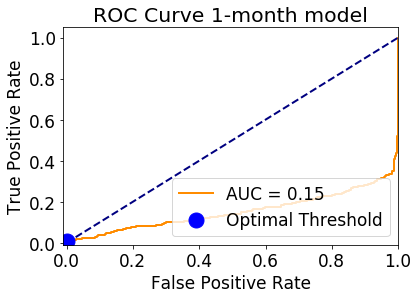

In [384]:
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot([opt_fpr],[opt_tpr],'bo', label='Optimal Threshold' %opt_threshold, markersize=15)
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve 1-month model')
plt.legend(loc="lower right")
plt.show()

In [395]:
survival_probs = cph.predict_survival_function(data_survival_test.drop(['is_open'],axis=1))

In [408]:
survival_length = 94 #[34, 94, 183, 269]

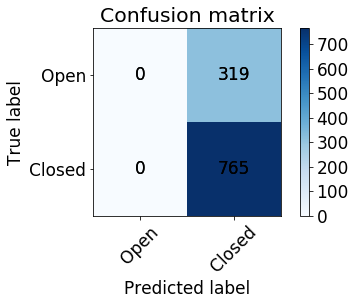

In [429]:
y_pred_roc = np.array([1 if survival_probs.loc[survival_length].iloc[i] > 0.00009 else 0 for i in range(data_survival_test.shape[0]) ])
#print "F1 Score:", f1_score(data_survival_test.is_open.values, y_pred_roc)
#print "Precision Score:", precision_score(data_survival_test.is_open.values, y_pred_roc)
#print "Recall Score:", recall_score(data_survival_test.is_open.values, y_pred_roc)
#print "Accuracy Score:", accuracy_score(data_survival_test.is_open.values, y_pred_roc)
plot_confusion_matrix(confusion_matrix(y_true=data_survival_test.is_open.values, y_pred=y_pred_roc))#, title='3 months')